In [1]:
from time import sleep
from pprint import pprint
from collections import deque
from deeptrade.run_openai import train, make_vec_env
from baselines.common.vec_env.vec_frame_stack import VecFrameStack
import numpy as np
from os import environ

import pandas as pd
import matplotlib.pyplot as plt

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

#PYTHONPATH=. python deeptrade/inspect_episodes.py --env=ladder --policy=ff_mlp --seed=8 --data=l2file:$DEEPTRADE_DATA --env.damp_eta=0.1 --env.burnin=2 --env.reward_fn=4 --env.mintime=60.0 --env.minprice=0.0 --env.episode_len=100 --env.max_inventory=10 --env.state_fn=micro --env.start_fee=0 --env.fee=0 --env.act_qty=0.1 --env.ntrain=1000 --env.neval=100  --load_path=../deeptrade-logs/24000 --verbose
policy='ff_mlp'
env_id = 'ladder'
seed=1
verbose=True
data = 'l2file:'+environ['DEEPTRADE_DATA']
#model_args={'load_path': '../deeptrade-logs/ff_mlp_rew_mm_pos_checkpoint'}
#model_args={'load_path': '../deeptrade-logs/24000'}
model_args={'load_path': '../deeptrade-logs/ff_mlp_pnl_damped-100/20000'}
model = train(env_id, env_args, model_args, 0, seed, policy, 1, data, False, verbose)
env = VecFrameStack(make_vec_tradeenv(
    env_id=env_id,
    num_env=1,
    data=data,
    env_args=env_args,
    seed=seed,
    rew_scale=env_args['rew_scale'],
    obnorm=env_args['obnorm'],
    rewnorm=env_args['rewnorm'],
    is_training=False), env_args['history_len'])
env_ = env.unwrapped.envs[0].unwrapped

Logging to /Users/atwigg/work/differentiable/deeptrade-logs/
policy=ff_mlp env=ladder nenvs=1 seed=1 total_timesteps=0
env_args={'burnin': 2, 'neval': 100, 'ntrain': 200, 'align_lvls_start': False, 'history_len': 5, 'episode_len': 1000, 'state_lvls': 23, 'state_w': 5, 'state_fn': 'micro', 'act_lvls': 11, 'act_w': 5, 'act_qty': 0.1, 'fee': 0.0, 'start_fee': 0.0, 'mintime': 60.0, 'minprice': 0.0, 'done_fn': 1, 'start_fn': 1, 'max_inventory': 10.0, 'inventory_control': 'off', 'cum_state': True, 'normalize': True, 'random_skip': False, 'end_on_target': True, 'target_alpha': 1.0, 'max_age': 60, 'damp_eta': 0.1, 'eval_overlap': False, 'booktype': 'shadow2', 'reward_fn': 'pnl_damped'}
model_args={'load_path': '../deeptrade-logs/ff_mlp_pnl_damped-100/20000'}
bookgen[BTC-USD]: got 100 files from /Users/atwigg/work/differentiable/deeptrade-data/gdax_book/BTC-USD/snapshots/t_60.0_p_0.0
bookgen[BTC-USD]: got 100 files from /Users/atwigg/work/differentiable/deeptrade-data/gdax_book/BTC-USD/snapshot

In [28]:
last_apv, last_rew=-1,-1
#while last_rew<0:
obs = env.reset()
step=0
done=False
actions,epinfos,rewards,values,pis = [],[],[],[],[]
while not done:
    act_model = model.act_model
    acts, vf, state, neglogp = act_model.step(obs) # step_mode(obs)
    # action dist
    pi = act_model.eval(obs, [c.logits for c in act_model.pd.categoricals])
    pi = [softmax(p).tolist() for p in pi]

    obs, rews, dones, infos = env.step(acts)
    # unpack vecenv
    action, value, reward, done, info = acts[0], vf[0], rews[0], dones[0], infos[0]
    step+=1

    #print(f'step={step} action={action} reward={reward:.4f} done={done}')
    #print(f'pi={pi}\n vf={value:.4f}')
    actions.append(action)
    epinfos.append(info)
    rewards.append(reward)
    values.append(value)
    pis.append(pi)

    epinfo = info.get('episode')
    if epinfo: # done
        assert done
        last_rew, last_apv = epinfo['r'], epinfo['apv']
        print('apv={:.3f}\t rew={:.3f}'.format(epinfo['apv'], epinfo['r']))

apv=-800.315	 rew=-1491.812


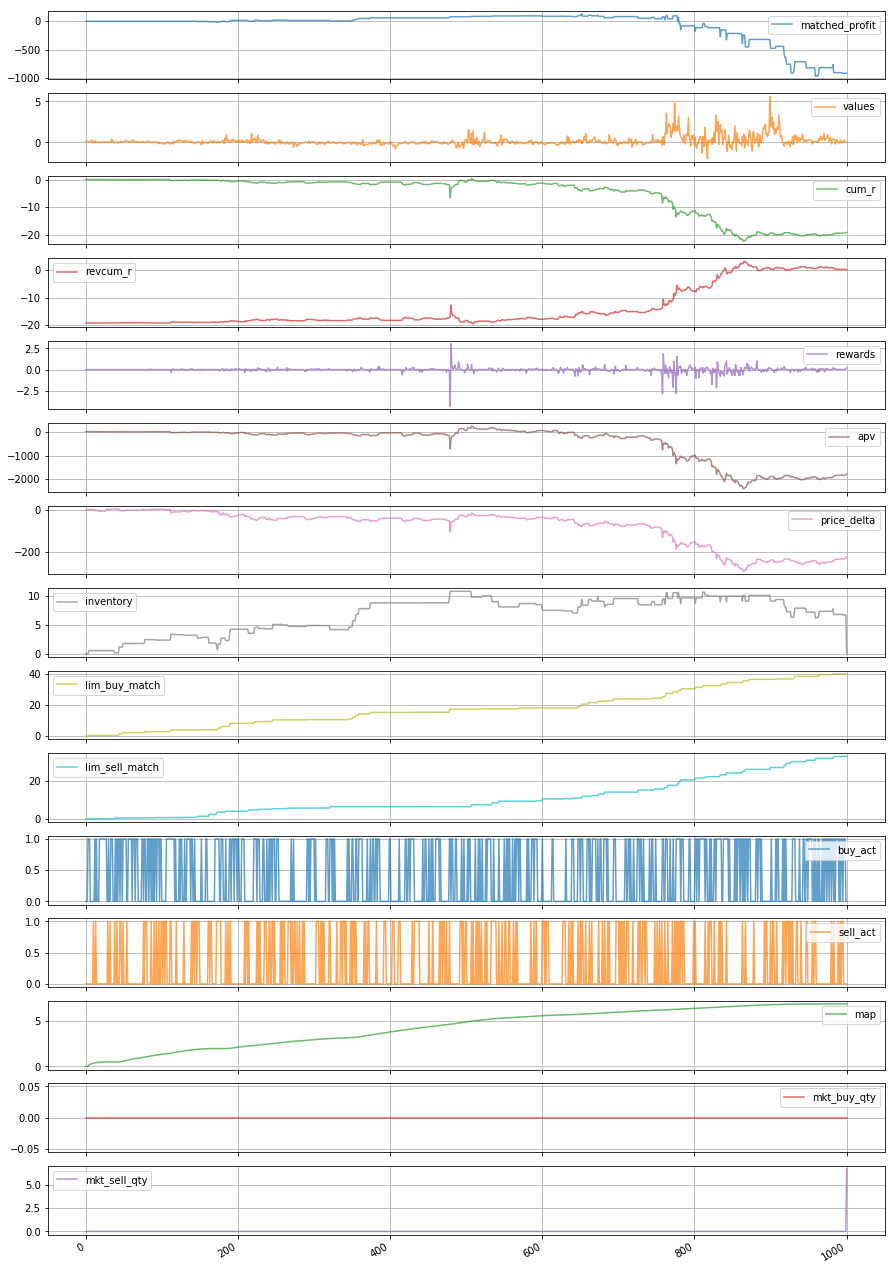

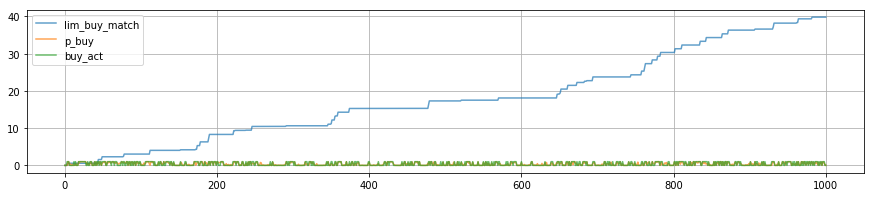

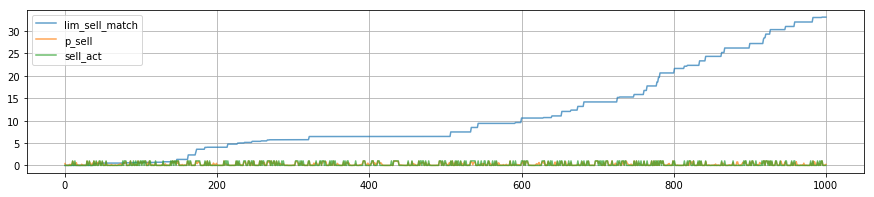

In [26]:
# actions,epinfos,rewards,values,pis
info_df=pd.DataFrame.from_records(epinfos)
info_df['values']=values
info_df['rewards']=rewards
act_probs=np.asarray(pis).reshape((len(pis), 2, 2))
info_df['p_buy']=act_probs[:,0,1]
info_df['p_sell']=act_probs[:,1,1]
action_arr = np.asarray(actions).astype(int)
info_df['buy_act']=action_arr[:,0]
info_df['sell_act']=action_arr[:,1]
info_df['revcum_r']=np.cumsum(rewards[::-1])[::-1]
info_df['cum_r']=np.cumsum(rewards)

cols=['matched_profit','values','cum_r','revcum_r','rewards','apv','price_delta','inventory','lim_buy_match','lim_sell_match','buy_act','sell_act','map','mkt_buy_qty','mkt_sell_qty']
info_df[cols].plot(subplots=True, figsize=(15,25),alpha=0.7,grid=True)

cols=['lim_buy_match','p_buy','buy_act']
info_df[cols].plot(subplots=False, figsize=(15,3),alpha=0.7,grid=True)

cols=['lim_sell_match','p_sell','sell_act']
info_df[cols].plot(subplots=False, figsize=(15,3),alpha=0.7,grid=True)

Text(0.5, 1.0, 'vf::rew')

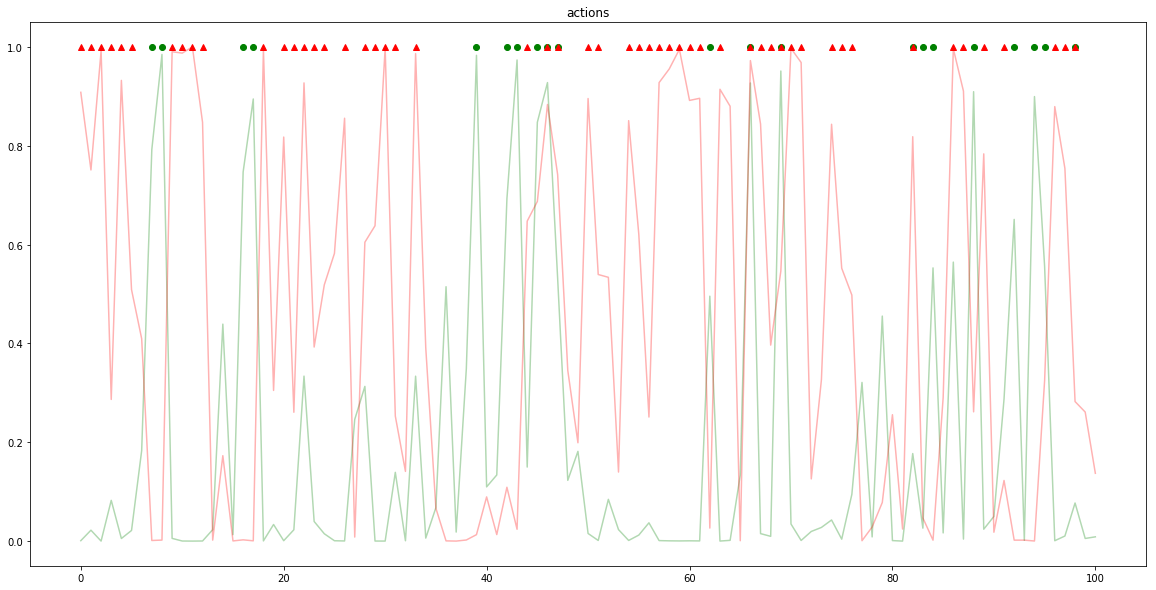

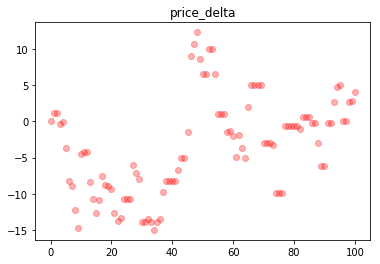

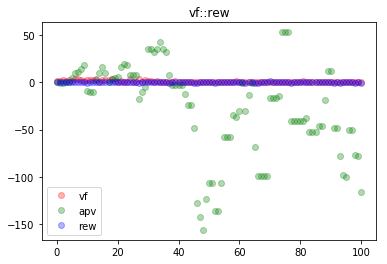

In [22]:
plt.figure(figsize=(20,10))
plt.plot(act_probs[:,0,1], 'g', alpha=0.3, label='buy')
xdata=np.where(action_arr[:,0])
plt.plot(xdata,action_arr[xdata,0],'go')
#plt.figure()
plt.plot(act_probs[:,1,1], 'r', alpha=0.3, label='sell')
xdata=np.where(action_arr[:,1])
plt.plot(xdata,action_arr[xdata,1],'r^')
plt.title('actions')

plt.figure()
plt.plot(info_df['price_delta'],'ro', alpha=0.3)
plt.title('price_delta')
plt.figure()
plt.plot(values, 'ro', alpha=0.3, label='vf')
plt.plot(info_df['apv'], 'go', alpha=0.3, label='apv')
plt.plot(rewards, 'bo', alpha=0.3, label='rew')
plt.legend()
plt.title('vf::rew')
